# ESTE ES EL NOTEBOOK DEL TFM

## Importar librerías

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import os
import re

import missingno as msno
import sys

from rapidfuzz import process, fuzz

import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_file(ruta_completa):
    try:
        file, extension = os.path.splitext(ruta_completa.lower())

        if extension == '.csv':
            df = pd.read_csv(ruta_completa)
        elif extension == '.parquet':
            df = pd.read_parquet(ruta_completa)
        elif extension == '.xlsx' or extension == 'xls':
            df =pd.read_excel(ruta_completa)
        
        return df
    
    except FileNotFoundError:
        print(f"Error: Archivo no encontrado en la ruta '{ruta_completa}'.")
        return None

    except Exception as e:
        print(f"Error inesperado: {e}")
        return None


In [3]:
def initial_exploration(df):
    print('El número de filas y columnas es:')
    display(df.shape)

    print('Primeras cinco filas:\n')
    display(df.head(5))

    print('Últimas cinco filas:\n')
    display(df.tail(5))

    print('Muestra aleatoria de filas:\n')
    display(df.sample(5))

    print('Las columnas del conjunto de datos son:')
    display(df.columns)

    print('Tipo de datos por columna:')
    display(df.dtypes)

    print('Número de columnas por tipo de datos:')
    display(df.dtypes.value_counts())

    print('Información más detallada:\n')
    display(df.info())
    display(df.describe())

    print('Número de valores únicos:')
    display(df.nunique())

    print('Valores únicos:\n')
    df_unique_values = pd.DataFrame(df.apply(lambda x: x.unique()))
    display(df_unique_values)

    print('Número de duplicados por columna:')
    df_duplicated = pd.DataFrame(df.apply(lambda x: x.duplicated()).sum().reset_index().rename(columns = {'index': 'Col', 0: 'Duplicates'}))
    df_duplicated = df_duplicated.sort_values(by = 'Duplicates', ascending = False).reset_index(drop=True)
    display(df_duplicated)

    print('Número de valores nulos por columna:')
    display(df.isnull().sum().reset_index().rename(columns = {'index': 'Col', 0: 'pct'}))
    
    print('Porcentaje de valores nulos por columna:')
    display(df.isnull().mean().mul(100).round(2).sort_values(ascending = False).reset_index(drop=True))

    print("## Valores nulos: Visualización")
    msno.bar(df, figsize = (6, 3), fontsize= 9)
    plt.show()
    print('-' * 100)

    print("## Visualización de patrones en valores nulos")
    msno.matrix(df, figsize = (6, 3), fontsize= 9, sparkline = False)
    plt.show()
    print('-' * 100)

    msno.heatmap(df, figsize = (6, 3), fontsize= 9)
    plt.show()
    print('-' * 100)

In [4]:
def convert_to_datetime(df):
    date_regex = r'^(?:(?:\d{4}[-/]\d{1,2}[-/]\d{1,2})|(?:\d{1,2}[-/]\d{1,2}[-/]\d{2,4}))(?:[\sT]+(?:[01]?\d|2[0-3]):[0-5]\d(?::[0-5]\d)?)?$'

    for col in df.columns:
        if df[col].dtype.name == 'object':
            mask = df[col].dropna().str.match(date_regex)
            if mask.all():
                df[col] = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)

    return df


In [5]:
def normalize_df(df):
    df.columns = df.columns.str.lower()
    str_cols = df.select_dtypes(include="object").columns
    df[str_cols] = df[str_cols].apply(
        lambda col: col.str.lower().str.strip()
    )
    return df

In [6]:
def comprobar_igualdad(df, columna1, columna2):
    return df[df[columna1]!=df[columna2]]

## Cargar datos

In [7]:
ruta = r'C:\Users\JAIME\Documents\Github\TFM-Sesgos-en-el-sistema-judicial-de-EEUU-\00_Data\00_Raw'

lista_ficheros = os.listdir(ruta)


In [8]:
dict_datos = {}

for fichero in lista_ficheros:
    ruta_completa = os.path.join(ruta, fichero)
    df = read_file(ruta_completa)
    clave = os.path.splitext(fichero.replace('-', '_'))[0]
    dict_datos[clave] = df

dict_datos.keys()

dict_keys(['compas_scores_raw', 'compas_scores_two_years'])

In [9]:
df['two_year_recid'].unique()

array([0, 1], dtype=int64)

## Exploración Inicial

EXPLORACIÓN DE compas_scores_raw 

El número de filas y columnas es:


(60843, 28)

Primeras cinco filas:



,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


Últimas cinco filas:



,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
60838,65667,79665,72038,Probation,West,James,NaN,Male,African-American,06/21/64,...,3,Medium with Override Consideration,8,Risk of Recidivism,0.16,8,High,New,1,0
60839,65667,79665,72038,Probation,West,James,NaN,Male,African-American,06/21/64,...,3,Medium with Override Consideration,18,Risk of Failure to Appear,35.00,10,High,New,1,0
60840,68603,79669,72042,PRETRIAL,Ryan,Michael,NaN,Male,Caucasian,02/06/85,...,1,Low,7,Risk of Violence,-2.75,2,Low,New,1,0
60841,68603,79669,72042,PRETRIAL,Ryan,Michael,NaN,Male,Caucasian,02/06/85,...,1,Low,8,Risk of Recidivism,-0.34,5,Medium,New,1,0
60842,68603,79669,72042,PRETRIAL,Ryan,Michael,NaN,Male,Caucasian,02/06/85,...,1,Low,18,Risk of Failure to Appear,16.00,2,Low,New,1,0


Muestra aleatoria de filas:



,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
33756,60632,69580,63090,Probation,WALKER,ROYSTON,G,Male,African-American,05/14/48,...,1,Low,7,Risk of Violence,-3.52,1,Low,New,1,0
28750,53792,67739,61422,Probation,HARBISON,COURTNEY,NaN,Male,Caucasian,12/07/89,...,2,Medium,8,Risk of Recidivism,-0.43,5,Medium,New,1,0
53,50873,57203,51984,PRETRIAL,sells,louis,NaN,Male,Caucasian,05/17/85,...,1,Low,18,Risk of Failure to Appear,18.00,3,Low,New,1,0
59573,68222,79212,71654,PRETRIAL,Williams,Ricardo,NaN,Male,African-American,05/14/75,...,1,Low,18,Risk of Failure to Appear,13.00,1,Low,New,1,0
31030,59831,68601,62199,Probation,Emanual,Michael,NaN,Male,African-American,01/30/78,...,3,Medium with Override Consideration,8,Risk of Recidivism,0.47,9,High,New,1,0


Las columnas del conjunto de datos son:


Index(['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName',
       'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text',
       'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason',
       'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus',
       'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
       'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
       'AssessmentType', 'IsCompleted', 'IsDeleted'],
      dtype='object')

Tipo de datos por columna:


Person_ID                    int64
AssessmentID                 int64
Case_ID                      int64
Agency_Text                 object
LastName                    object
FirstName                   object
MiddleName                  object
Sex_Code_Text               object
Ethnic_Code_Text            object
DateOfBirth                 object
ScaleSet_ID                  int64
ScaleSet                    object
AssessmentReason            object
Language                    object
LegalStatus                 object
CustodyStatus               object
MaritalStatus               object
Screening_Date              object
RecSupervisionLevel          int64
RecSupervisionLevelText     object
Scale_ID                     int64
DisplayText                 object
RawScore                   float64
DecileScore                  int64
ScoreText                   object
AssessmentType              object
IsCompleted                  int64
IsDeleted                    int64
dtype: object

Número de columnas por tipo de datos:


object     18
int64       9
float64     1
Name: count, dtype: int64

Información más detallada:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60843 entries, 0 to 60842
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person_ID                60843 non-null  int64  
 1   AssessmentID             60843 non-null  int64  
 2   Case_ID                  60843 non-null  int64  
 3   Agency_Text              60843 non-null  object 
 4   LastName                 60843 non-null  object 
 5   FirstName                60843 non-null  object 
 6   MiddleName               15624 non-null  object 
 7   Sex_Code_Text            60843 non-null  object 
 8   Ethnic_Code_Text         60843 non-null  object 
 9   DateOfBirth              60843 non-null  object 
 10  ScaleSet_ID              60843 non-null  int64  
 11  ScaleSet                 60843 non-null  object 
 12  AssessmentReason         60843 non-null  object 
 13  Language                 60843 non-null  object 

None

,Person_ID,AssessmentID,Case_ID,ScaleSet_ID,RecSupervisionLevel,Scale_ID,RawScore,DecileScore,IsCompleted,IsDeleted
count,60843.000000,60843.000000,60843.000000,60843.000000,60843.000000,60843.000000,60843.000000,60843.000000,60843.0,60843.0
mean,53683.206154,68061.029190,60209.128149,21.819536,1.630048,11.000000,5.081457,3.571701,1.0,0.0
std,14363.648515,7320.208226,9638.501654,0.932614,0.944220,4.966596,10.080518,2.617854,0.0,0.0
min,656.000000,649.000000,350.000000,17.000000,1.000000,7.000000,-4.790000,-1.000000,1.0,0.0
25%,52039.000000,62582.000000,56021.000000,22.000000,1.000000,7.000000,-2.090000,1.000000,1.0,0.0
50%,57321.000000,68229.000000,61261.000000,22.000000,1.000000,8.000000,-0.710000,3.000000,1.0,0.0
75%,62748.000000,73870.000000,66554.000000,22.000000,2.000000,18.000000,14.000000,5.000000,1.0,0.0
max,68608.000000,79678.000000,72045.000000,22.000000,4.000000,18.000000,51.000000,10.000000,1.0,0.0


Número de valores únicos:


Person_ID                  18610
AssessmentID               20281
Case_ID                    19530
Agency_Text                    4
LastName                   10896
FirstName                   7225
MiddleName                  1870
Sex_Code_Text                  2
Ethnic_Code_Text               9
DateOfBirth                10382
ScaleSet_ID                    2
ScaleSet                       2
AssessmentReason               1
Language                       2
LegalStatus                    7
CustodyStatus                  6
MaritalStatus                  7
Screening_Date               705
RecSupervisionLevel            4
RecSupervisionLevelText        4
Scale_ID                       3
DisplayText                    3
RawScore                     659
DecileScore                   11
ScoreText                      3
AssessmentType                 2
IsCompleted                    1
IsDeleted                      1
dtype: int64

Valores únicos:



,0
Person_ID,"[50844, 50848, 50855, 50850, 50839, 50852, 508..."
AssessmentID,"[57167, 57174, 57181, 57176, 57162, 57179, 571..."
Case_ID,"[51950, 51956, 51963, 51958, 51945, 51961, 519..."
Agency_Text,"[PRETRIAL, Probation, DRRD, Broward County]"
LastName,"[Fisher, KENDALL, DAYES, Debe, McLaurin, Holla..."
FirstName,"[Kevin, KEVIN, DANIEL, Mikerlie, Stephanie, Te..."
MiddleName,"[nan, George, Nicole, B, Joseph, Lavon, OLVERA..."
Sex_Code_Text,"[Male, Female]"
Ethnic_Code_Text,"[Caucasian, African-American, Hispanic, Other,..."
DateOfBirth,"[12/05/92, 09/16/84, 08/25/94, 10/09/94, 06/29..."


Número de duplicados por columna:


,Col,Duplicates
0,IsDeleted,60842
1,IsCompleted,60842
2,AssessmentReason,60842
3,AssessmentType,60841
4,Sex_Code_Text,60841
5,ScaleSet_ID,60841
6,ScaleSet,60841
7,Language,60841
8,DisplayText,60840
9,Scale_ID,60840


Número de valores nulos por columna:


,Col,pct
0,Person_ID,0
1,AssessmentID,0
2,Case_ID,0
3,Agency_Text,0
4,LastName,0
5,FirstName,0
6,MiddleName,45219
7,Sex_Code_Text,0
8,Ethnic_Code_Text,0
9,DateOfBirth,0


Porcentaje de valores nulos por columna:


0     74.32
1      0.07
2      0.00
3      0.00
4      0.00
5      0.00
6      0.00
7      0.00
8      0.00
9      0.00
10     0.00
11     0.00
12     0.00
13     0.00
14     0.00
15     0.00
16     0.00
17     0.00
18     0.00
19     0.00
20     0.00
21     0.00
22     0.00
23     0.00
24     0.00
25     0.00
26     0.00
27     0.00
dtype: float64

## Valores nulos: Visualización


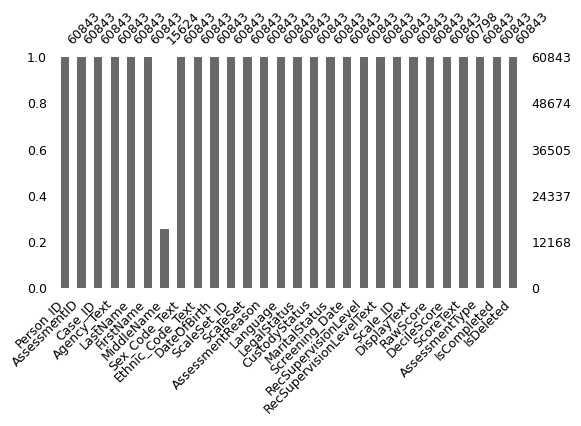

----------------------------------------------------------------------------------------------------
## Visualización de patrones en valores nulos


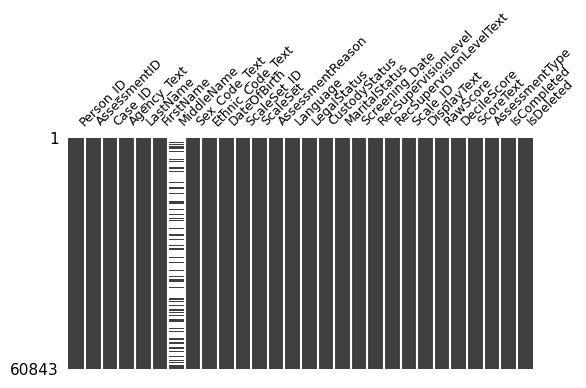

----------------------------------------------------------------------------------------------------


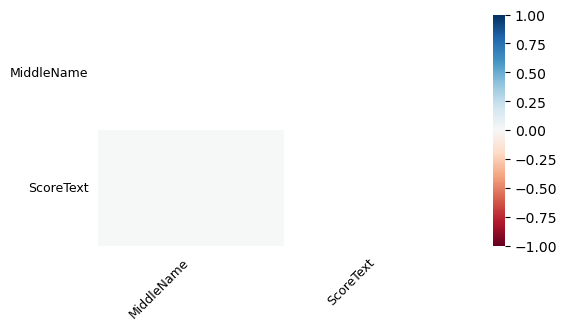

----------------------------------------------------------------------------------------------------
EXPLORACIÓN DE compas_scores_two_years 

El número de filas y columnas es:


(7214, 53)

Primeras cinco filas:



,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


Últimas cinco filas:



,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0
7213,11001,florencia sanmartin,florencia,sanmartin,2014-06-30,Female,1992-12-18,23,Less than 25,Hispanic,...,4,Low,2014-06-30,2015-03-15,2015-03-15,2,0,258,0,1


Muestra aleatoria de filas:



,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
2133,3267,byran george,byran,george,2013-08-03,Male,1989-01-23,27,25 - 45,African-American,...,3,Low,2013-08-03,2013-08-03,2013-08-04,0,1,972,0,0
1769,2683,rita iscaro,rita,iscaro,2013-10-09,Male,1968-10-30,47,Greater than 45,Caucasian,...,1,Low,2013-10-09,2013-10-08,2013-10-09,0,0,905,0,0
2668,4069,veron elliot,veron,elliot,2013-09-23,Male,1991-05-05,24,Less than 25,Caucasian,...,6,Medium,2013-09-23,2013-09-23,2013-09-23,3,0,568,1,1
782,1191,corey haseley,corey,haseley,2013-08-12,Male,1993-08-27,22,Less than 25,Caucasian,...,6,Medium,2013-08-12,2013-08-12,2013-08-15,0,3,649,1,1
6064,9248,anthony bass,anthony,bass,2013-03-26,Male,1954-05-08,61,Greater than 45,African-American,...,4,Low,2013-03-26,2013-03-25,2013-03-26,25,0,1102,0,0


Las columnas del conjunto de datos son:


Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

Tipo de datos por columna:


id                           int64
name                        object
first                       object
last                        object
compas_screening_date       object
sex                         object
dob                         object
age                          int64
age_cat                     object
race                        object
juv_fel_count                int64
decile_score                 int64
juv_misd_count               int64
juv_other_count              int64
priors_count                 int64
days_b_screening_arrest    float64
c_jail_in                   object
c_jail_out                  object
c_case_number               object
c_offense_date              object
c_arrest_date               object
c_days_from_compas         float64
c_charge_degree             object
c_charge_desc               object
is_recid                     int64
r_case_number               object
r_charge_degree             object
r_days_from_arrest         float64
r_offense_date      

Número de columnas por tipo de datos:


object     33
int64      16
float64     4
Name: count, dtype: int64

Información más detallada:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 

None

,id,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,violent_recid,is_violent_recid,decile_score.1,v_decile_score,priors_count.1,start,end,event,two_year_recid
count,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,6907.000000,7192.000000,7214.000000,2316.000000,0.0,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000,7214.000000
mean,5501.255753,34.817993,0.067230,4.509565,0.090934,0.109371,3.472415,3.304763,57.731368,0.481148,20.269430,NaN,0.113529,4.509565,3.691849,3.472415,11.465068,553.436651,0.382867,0.450652
std,3175.706870,11.888922,0.473972,2.856396,0.485239,0.501586,4.882538,75.809505,329.740215,0.499679,74.871668,NaN,0.317261,2.856396,2.510148,4.882538,46.954563,399.020583,0.486120,0.497593
min,1.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-414.000000,0.000000,0.000000,-1.000000,NaN,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2735.250000,25.000000,0.000000,2.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,2.000000,1.000000,0.000000,0.000000,148.250000,0.000000,0.000000
50%,5509.500000,31.000000,0.000000,4.000000,0.000000,0.000000,2.000000,-1.000000,1.000000,0.000000,0.000000,NaN,0.000000,4.000000,3.000000,2.000000,0.000000,530.500000,0.000000,0.000000
75%,8246.500000,42.000000,0.000000,7.000000,0.000000,0.000000,5.000000,0.000000,2.000000,1.000000,1.000000,NaN,0.000000,7.000000,5.000000,5.000000,1.000000,914.000000,1.000000,1.000000
max,11001.000000,96.000000,20.000000,10.000000,13.000000,17.000000,38.000000,1057.000000,9485.000000,1.000000,993.000000,NaN,1.000000,10.000000,10.000000,38.000000,937.000000,1186.000000,1.000000,1.000000


Número de valores únicos:


id                         7214
name                       7158
first                      2800
last                       3950
compas_screening_date       690
sex                           2
dob                        5452
age                          65
age_cat                       3
race                          6
juv_fel_count                11
decile_score                 10
juv_misd_count               10
juv_other_count              10
priors_count                 37
days_b_screening_arrest     423
c_jail_in                  6907
c_jail_out                 6880
c_case_number              7192
c_offense_date              927
c_arrest_date               580
c_days_from_compas          499
c_charge_degree               2
c_charge_desc               437
is_recid                      2
r_case_number              3471
r_charge_degree              10
r_days_from_arrest          201
r_offense_date             1075
r_charge_desc               340
r_jail_in                   972
r_jail_o

Valores únicos:



,0
id,"[1, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 1..."
name,"[miguel hernandez, kevon dixon, ed philo, marc..."
first,"[miguel, kevon, ed, marcu, bouthy, marsha, edw..."
last,"[hernandez, dixon, philo, brown, pierrelouis, ..."
compas_screening_date,"[2013-08-14, 2013-01-27, 2013-04-14, 2013-01-1..."
sex,"[Male, Female]"
dob,"[1947-04-18, 1982-01-22, 1991-05-14, 1993-01-2..."
age,"[69, 34, 24, 23, 43, 44, 41, 39, 21, 27, 37, 4..."
age_cat,"[Greater than 45, 25 - 45, Less than 25]"
race,"[Other, African-American, Caucasian, Hispanic,..."


Número de duplicados por columna:


,Col,Duplicates
0,v_type_of_assessment,7213
1,violent_recid,7213
2,type_of_assessment,7213
3,two_year_recid,7212
4,is_violent_recid,7212
5,c_charge_degree,7212
6,is_recid,7212
7,sex,7212
8,event,7212
9,score_text,7211


Número de valores nulos por columna:


,Col,pct
0,id,0
1,name,0
2,first,0
3,last,0
4,compas_screening_date,0
5,sex,0
6,dob,0
7,age,0
8,age_cat,0
9,race,0


Porcentaje de valores nulos por columna:


0     100.00
1      88.65
2      88.65
3      88.65
4      88.65
5      84.24
6      67.90
7      67.90
8      67.90
9      52.69
10     51.89
11     51.89
12     51.89
13     16.07
14      4.26
15      4.26
16      4.26
17      3.27
18      3.27
19      0.40
20      0.30
21      0.30
22      0.00
23      0.00
24      0.00
25      0.00
26      0.00
27      0.00
28      0.00
29      0.00
30      0.00
31      0.00
32      0.00
33      0.00
34      0.00
35      0.00
36      0.00
37      0.00
38      0.00
39      0.00
40      0.00
41      0.00
42      0.00
43      0.00
44      0.00
45      0.00
46      0.00
47      0.00
48      0.00
49      0.00
50      0.00
51      0.00
52      0.00
dtype: float64

## Valores nulos: Visualización


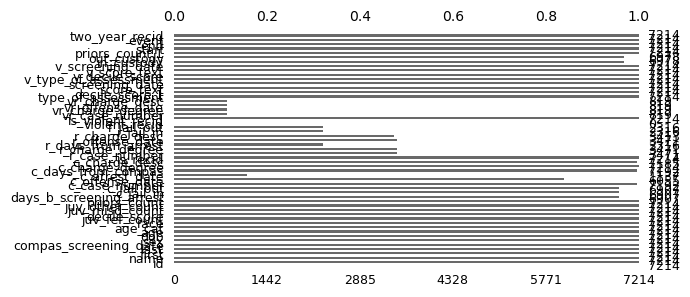

----------------------------------------------------------------------------------------------------
## Visualización de patrones en valores nulos


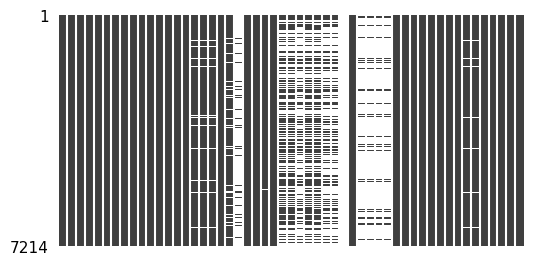

----------------------------------------------------------------------------------------------------


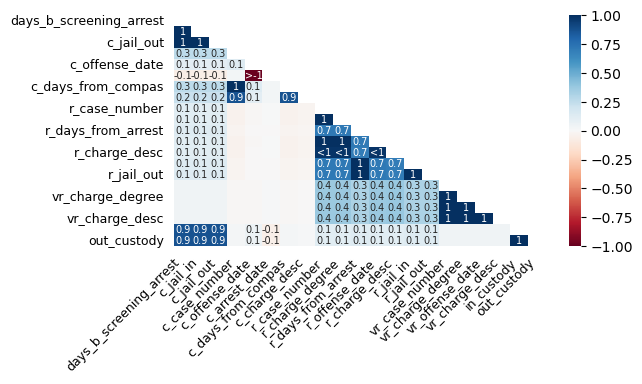

----------------------------------------------------------------------------------------------------


In [10]:
for k, v in dict_datos.items():
    print(f"EXPLORACIÓN DE {k} \n")
    initial_exploration(v)

In [11]:
df_compas_raw = dict_datos['compas_scores_raw'].copy()
df_compas_two_years = dict_datos['compas_scores_two_years'].copy()

In [12]:
df_compas_raw = convert_to_datetime(df_compas_raw)
df_compas_two_years = convert_to_datetime(df_compas_two_years)

In [13]:
df_compas_raw = normalize_df(df_compas_raw)
df_compas_two_years = normalize_df(df_compas_two_years)

In [14]:
df_compas_raw["name"] = df_compas_raw["firstname"] + ' ' + df_compas_raw["lastname"]

In [15]:
df_compas_raw.duplicated().sum()

0

In [16]:
variables_df1 = ['person_id',
 'agency_text',
 'lastname',
 'firstname',
 'middlename',
 'sex_code_text',
 'ethnic_code_text',
 'dateofbirth',
 'maritalstatus',
 'screening_date'
]

variables_df2 = [
 'name',
 'sex',
 'dob',
 'age',
 'age_cat',
 'race',
 'decile_score',
 'v_decile_score',
 'is_recid',
 'is_violent_recid',
 'score_text',
 'screening_date',
 'two_year_recid'
 ]

In [17]:
df_raw_clean = df_compas_raw[variables_df1].copy()
df_two_years_clean = df_compas_two_years[variables_df2].copy()

In [18]:
df_raw_clean.columns

Index(['person_id', 'agency_text', 'lastname', 'firstname', 'middlename',
       'sex_code_text', 'ethnic_code_text', 'dateofbirth', 'maritalstatus',
       'screening_date'],
      dtype='object')

In [19]:
df_raw_clean = df_raw_clean.drop_duplicates()
df_raw_clean = df_raw_clean.rename(columns={"dateofbirth" : "dob"})

In [20]:
df_raw_clean["name"] = df_raw_clean["firstname"] + " " + df_raw_clean["lastname"]

In [21]:
df_raw_clean = df_raw_clean.drop_duplicates(subset=["person_id"])

In [22]:
df_two_years_clean.shape

(7214, 13)

In [23]:
# Fecha con isrecid = 1 se pasa de abril, limpiar
df_two_years_clean = df_two_years_clean[df_two_years_clean["screening_date"] <= pd.to_datetime('2014-04-01')]

In [24]:
df_two_years_clean.shape

(6216, 13)

In [25]:
df_raw_clean.head()

,person_id,agency_text,lastname,firstname,middlename,sex_code_text,ethnic_code_text,dob,maritalstatus,screening_date,name
0,50844,pretrial,fisher,kevin,NaN,male,caucasian,1992-12-05,single,2013-01-01,kevin fisher
3,50848,pretrial,kendall,kevin,NaN,male,caucasian,1984-09-16,married,2013-01-01,kevin kendall
6,50855,pretrial,dayes,daniel,NaN,male,african-american,1994-08-25,single,2013-01-01,daniel dayes
9,50850,pretrial,debe,mikerlie,george,female,african-american,1994-10-09,significant other,2013-01-01,mikerlie debe
12,50839,pretrial,mclaurin,stephanie,nicole,female,african-american,1985-06-29,single,2013-01-01,stephanie mclaurin


In [26]:
# Crear tuplas con las columnas clave
# raw_keys = set(tuple(x) for x in df_raw_clean[["name","dob","screening_date"]].values)
# two_keys = set(tuple(x) for x in df_two_years_clean[["name","dob","screening_date"]].values)

# Ver qué filas de two_years no están en raw
# faltan = df_two_years_clean[[
#     "name","dob","screening_date"
# ]][[tuple(x) not in raw_keys for x in df_two_years_clean[["name","dob","screening_date"]].values]]

# print(faltan)

In [27]:
df_raw_clean.query("lastname == 'knauff'")

,person_id,agency_text,lastname,firstname,middlename,sex_code_text,ethnic_code_text,dob,maritalstatus,screening_date,name
12645,29231,pretrial,knauff,elloitt,NaN,male,caucasian,2067-05-01,single,2013-05-02,elloitt knauff


In [28]:
# Limpiar fechas (algunas tienen +100 años)
# Buscar nombres por similitud (fuzzywuzzy?)

In [29]:
df_raw_clean.columns

Index(['person_id', 'agency_text', 'lastname', 'firstname', 'middlename',
       'sex_code_text', 'ethnic_code_text', 'dob', 'maritalstatus',
       'screening_date', 'name'],
      dtype='object')

In [30]:
df_raw_clean['dob'] = df_raw_clean['dob'].apply(lambda x : x - pd.DateOffset(years = 100) if x > pd.to_datetime('2000-01-01') else x)

In [31]:
df_raw_aux_dob = df_raw_clean.query("dob > '2000-01-01'")

In [32]:
df_raw_aux_dob.dtypes

person_id                    int64
agency_text                 object
lastname                    object
firstname                   object
middlename                  object
sex_code_text               object
ethnic_code_text            object
dob                 datetime64[ns]
maritalstatus               object
screening_date      datetime64[ns]
name                        object
dtype: object

In [33]:

nombres_df_raw = df_raw_clean['name'].unique().tolist()

# nombres_df_two_years = df_two_years_clean['name'].unique().tolist()     #este es el weno


# def fuzzy_replace(name, nombres_df_two_years, threshold=85):
    
#     result = process.extractOne(
#         name,
#         nombres_df_two_years,
#         scorer=fuzz.token_sort_ratio
#     )
    
#     if result is None:
#         return name
    
#     match = result[0]
#     score = result[1]
    
#     return match if score >= threshold else name

# df_raw_clean["name"] = df_raw_clean["name"].apply(
#     lambda x: fuzzy_replace(x, nombres_df_two_years)
# )# 

In [34]:
#nombres_df_raw = df_raw_clean['name'].unique().tolist()

# nombres_df_two_years = df_two_years_clean['name'].unique().tolist()  

def fuzzy_replace_safe(row, df_maestro, threshold=85):
    
    posibles = df_maestro[df_maestro["dob"] == row["dob"]]
    
    if posibles.empty:
        return row["name"]
    
    result = process.extractOne(
        row["name"],
        posibles["name"].tolist(),
        scorer=fuzz.token_sort_ratio
    )
    
    if result is None:
        return row["name"]
    
    match, score = result[0], result[1]
    
    return match if score >= threshold else row["name"]

df_raw_clean["name"] = df_raw_clean.apply(
    lambda row: fuzzy_replace_safe(row, df_two_years_clean),
    axis=1
)

In [49]:
test_merge = pd.merge(df_raw_clean, df_two_years_clean,on=["dob", 'name', 'screening_date'], how='inner')           #shape two years clean de 6216

In [50]:
test_merge.shape        #coon dob y name 6157
                        #con name y screening_date 6157
                        #coon dob y screening_date 6074

(6040, 21)

In [51]:
df_two_years_clean.shape

(6216, 13)

In [43]:
# condicion = df_two_years_clean.name.duplicated() == True

# df_two_years_clean[condicion]



In [44]:
# condicion_2 = df_two_years_clean.name == 'michael williams'

# df_two_years_clean[condicion_2]

In [52]:
test_merge.columns

Index(['person_id', 'agency_text', 'lastname', 'firstname', 'middlename',
       'sex_code_text', 'ethnic_code_text', 'dob', 'maritalstatus',
       'screening_date', 'name', 'sex', 'age', 'age_cat', 'race',
       'decile_score', 'v_decile_score', 'is_recid', 'is_violent_recid',
       'score_text', 'two_year_recid'],
      dtype='object')

In [53]:
cols = df_two_years_clean.columns.tolist()

df2_tuples = list(test_merge[cols].itertuples(index=False, name=None))

df1_no_match = df_two_years_clean[~df_two_years_clean[cols].apply(tuple, axis=1).isin(df2_tuples)]

In [57]:
df1_no_match

,name,sex,dob,age,age_cat,race,decile_score,v_decile_score,is_recid,is_violent_recid,score_text,screening_date,two_year_recid
8,elizabeth thieme,female,1976-06-03,39,25 - 45,caucasian,1,1,0,0,low,2014-03-16,0
63,omar wilson,male,1993-06-13,22,less than 25,african-american,4,6,1,0,low,2013-11-16,1
76,troy smith,male,1993-09-21,22,less than 25,african-american,3,3,1,0,low,2013-08-25,1
87,israel doyle,male,1992-12-07,23,less than 25,african-american,7,8,1,0,medium,2014-03-17,1
159,dwayne powell,male,1961-03-09,55,greater than 45,african-american,1,1,0,0,low,2013-06-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7084,joshua marlowe,male,1990-05-15,25,25 - 45,caucasian,9,7,1,0,high,2013-08-05,1
7127,jeanne allen,female,1979-05-15,36,25 - 45,other,1,1,0,0,low,2013-09-16,0
7146,norberto nieves,male,1985-01-19,31,25 - 45,hispanic,6,5,0,0,medium,2013-09-22,0
7197,jarvis yates,male,1987-08-27,28,25 - 45,african-american,2,2,0,0,low,2014-02-27,0


In [59]:
df_two_years_clean[df_two_years_clean.name == 'elizabeth thieme']

,name,sex,dob,age,age_cat,race,decile_score,v_decile_score,is_recid,is_violent_recid,score_text,screening_date,two_year_recid
8,elizabeth thieme,female,1976-06-03,39,25 - 45,caucasian,1,1,0,0,low,2014-03-16,0


In [60]:
df_raw_clean[df_raw_clean.name == 'elizabeth thieme']

,person_id,agency_text,lastname,firstname,middlename,sex_code_text,ethnic_code_text,dob,maritalstatus,screening_date,name
38343,61996,pretrial,thieme,elizabeth,anne,female,caucasian,1976-06-06,single,2014-03-16,elizabeth thieme


In [ ]:
df_two_years_clean.compare(test_merge)



ValueError: Can only compare identically-labeled (both index and columns) DataFrame objects